![](dataset/food_images/_kiwi_kitchen_4.jpg)
<p style="color:#657c2b;font-size:32px;">YOUR RECIPE RECOMMENDER</p>

# BACKGROUND

Food waste accounts for about 12 per cent of the total waste generated in Singapore. Therefore, there is a need to manage food waste holistically. Reducing food wastage, redistributing unsold or excess food, and recycling/treating food waste are important components of our national waste management strategies to work towards Singapore becoming a Zero Waste Nation.

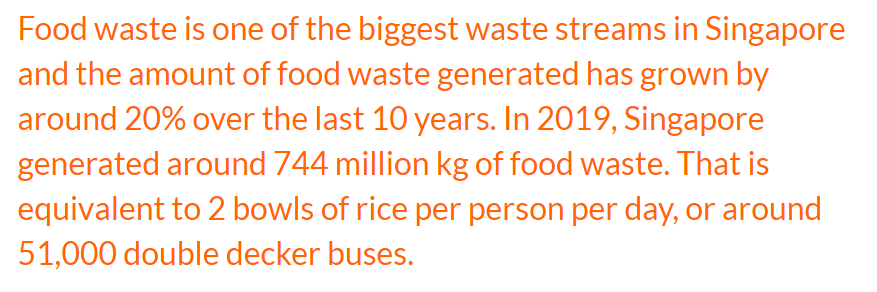

Food waste makes up about half of the average 1.5kg of waste disposed of by each household in Singapore daily. Of which, more than half of household food waste can be prevented, with rice, noodles and bread being the most commonly wasted food items [(*source*)](https://www.towardszerowaste.gov.sg/foodwaste/). The diagram below shows Singapore’s food waste management hierarchy, in order of priorities, with the first priority being to prevent food waste from being generated. [(*source*)](https://www.nea.gov.sg/our-services/waste-management/3r-programmes-and-resources/food-waste-management)

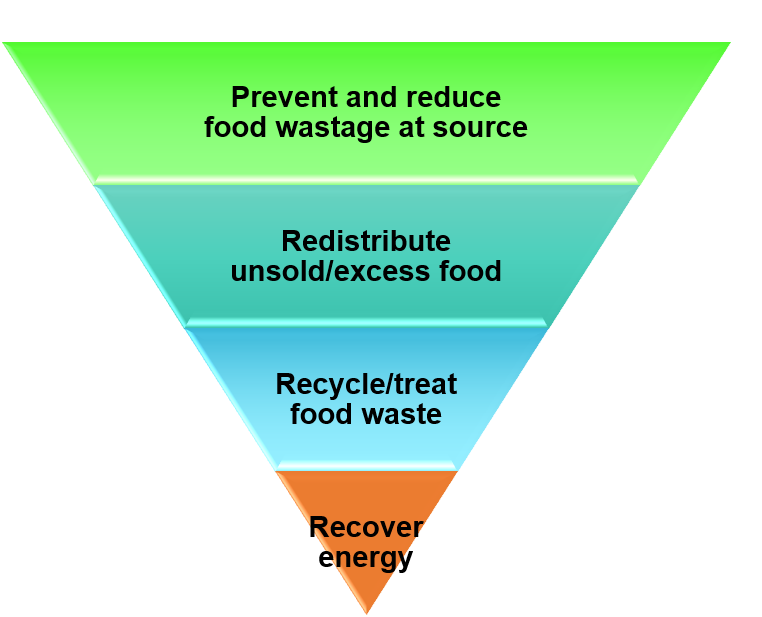

Due to the pandemic, many of us have settled into new routines that involve a lot more working from home & home cooking. Consumers who are working from home no longer frequent the lunch spots around their offices. However, most of the time we will end up accumulating unused ingredients. If remain unused, these ingredients turn into food wastage. To address this problem, a recipe recommendation system that would take users input for the ingredients, and produce an output of recipes that uses the ingredients were created.

# OBJECTIVES & OVERVIEWS

The primary dataset is from [Epicurious](http://www.epicurious.com/recipes-menus) that Hugodarwood scrapped and generously shared to [Kaggle](https://www.kaggle.com/datasets/hugodarwood/epirecipes). The data contains 20k+ recipes in JSON format. This dataser provides rich and interesting features such as: list of ingredients, directions, categories, nutritional information, images as well as images. Additionally, [BBC Food](https://www.bbc.co.uk/food/ingredients/a-z/a/1) website was scrapped to extract around 1100 ingredient names to help standardize the ingredients in the dataset.

In order to build the recipe recommendation system, each ingredients in the ingredient list have to be extracted to remove redundant information that would not help distinguish recipes ('onion' has to be extracted from '2 medium onions, chopped' and 'brown lentils' has to be extracted from '1 cup dried brown lentils'). Two methods were used to extract the key ingredients: The first method was to identify nouns from the ingredient list using NLTK. The second method was by matching the ingredient to the list of ingredients scrapped from with bbc.com. The second method was found to be more effective in extracting the key ingredients.

Next, TF-IDF was used to generate embeddings as it gives us better distinguishing power between recipes by favoring unique ingredients, and unfavoring common ingredients such as salt, pepper, etc. The recommendation model computes the vector of each imputted ingredient and all recipes in the dataset. It then outputs the top 3 most similar recipes for user to choose from.

Additionally, content-based recommendation system was built using a cosine similarity which enables us to recommend recipes to people based on the original recipes that they selected. To measure the similarity between recipes, 'category' features was used. The 'category' feature contains key information such as: the main ingredient of the recipe (i.e. Tomato, Egg), ocassion (i.e. New Year, Christmas, Birthday), the dietary information (i.e. Peanut-Free, Glutten-Free), as well as the timing (i.e. Breakfast, Lunch). An example of a 'category' for 'Lentil, Apple, and Turkey Wrap' is Kid-Friendly, Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, , Apple, Lentil, Lettuce.

Finally, an application incorporating all of the features mentioned above was developed using [streamlit](https://streamlit.io/).

**To summarize, the objectives of this projects are:**
1. To produce a model capable of recommending recipes based on ingredients available
2. To filter recipes based on dietary preferences (vegetarian, peanut free, gluten free, low calories, kid friendly)
3. To produce a 'you might also like' feature which recommends new recipes based on the originally selected recipe

# 01. LIBRARY & DATASETS

In [1]:
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter
from IPython.display import Image, display

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

from pattern.text.en import singularize
from tqdm import tqdm 
tqdm.pandas()

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 120

## 01. df_1 (Main Epicurious Dataframe)

This dataset is scrapped from [Epicurious](http://www.epicurious.com/recipes-menus) and uploaded to [Kaggle](https://www.kaggle.com/datasets/hugodarwood/epirecipes) by Hugodarwood.

In [2]:
df_1 = pd.read_json('dataset/full_format_recipes.json')

In [3]:
df_1.head(3)

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...",559.0
1,"[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]",403.0,"This uses the same ingredients found in boudin blanc, the classic French white sausage. Start two days before serving.",18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...",1439.0
2,"[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...",165.0


In [4]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   directions   20111 non-null  object             
 1   fat          15908 non-null  float64            
 2   date         20111 non-null  datetime64[ns, UTC]
 3   categories   20111 non-null  object             
 4   calories     15976 non-null  float64            
 5   desc         13495 non-null  object             
 6   protein      15929 non-null  float64            
 7   rating       20100 non-null  float64            
 8   title        20111 non-null  object             
 9   ingredients  20111 non-null  object             
 10  sodium       15974 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [5]:
# remove recipe with no ingredients
df_1['length'] = df_1['ingredients'].str.len()
df_1 = df_1[df_1['length'] > 0]

In [6]:
# select features to be used, drop duplicated title
df_1 = df_1[['title', 'ingredients', 'categories', 'directions', 'calories']]
df_1 = df_1.drop_duplicates(subset = 'title')

In [7]:
# the title of the recipe has a space
# convert ' Lentil, Apple, and Turkey Wrap' to 'Lentil, Apple, and Turkey Wrap'
df_1['title'] = [x.strip() for x in df_1['title']]
df_1['title'][0]

'Lentil, Apple, and Turkey Wrap'

In [8]:
df_1 = df_1.set_index('title')

In [9]:
df_1.head(3)

,ingredients,categories,directions,calories
title,,,,
"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0
Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0
Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0


## 02. df_2 (Epicurious Dataframe with Image)

This dataset is scrapped from [Epicurious](http://www.epicurious.com/recipes-menus) and uploaded to [Kaggle](https://www.kaggle.com/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images) by Sakshi Goel.

In [10]:
df_2 = pd.read_csv('./dataset/food_ingredients.csv')

In [11]:
df_2.rename(columns = {'Title': 'title'}, inplace = True)

In [12]:
df_2.head(3)

,Unnamed: 0,title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)'...","Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let s...",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)'..."
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (about 1 inch in diameter)', '2 teaspoons kosher salt', '¾ teaspoon fin...","Preheat oven to 400°F and line a rimmed baking sheet with parchment. In a large bowl, whisk the egg whites until foa...",crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (about 1 inch in diameter)', '2 teaspoons kosher salt', '¾ teaspoon fin..."
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', '1 tsp. garlic powder', '1 tsp. onion powder', '1 tsp. smoked paprika'...",Place a rack in middle of oven; preheat to 400°. Bring evaporated milk and whole milk to a bare simmer in a large sa...,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', '1 tsp. garlic powder', '1 tsp. onion powder', '1 tsp. smoked paprika'..."


In [13]:
# select features to be used, drop duplicated title
df_2 = df_2[['title', 'Image_Name']]
df_2.drop_duplicates(subset = 'title', inplace = True)

In [14]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13310 entries, 0 to 13504
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       13309 non-null  object
 1   Image_Name  13310 non-null  object
dtypes: object(2)
memory usage: 312.0+ KB


In [15]:
df_2 = df_2.set_index('title')

In [16]:
df_2.head(3)

,Image_Name
title,
Miso-Butter Roast Chicken With Acorn Squash Panzanella,miso-butter-roast-chicken-acorn-squash-panzanella
Crispy Salt and Pepper Potatoes,crispy-salt-and-pepper-potatoes-dan-kluger
Thanksgiving Mac and Cheese,thanksgiving-mac-and-cheese-erick-williams


## 03. Combining df_1 and df_2

In [17]:
df = df_1.join(df_2)

In [18]:
df.head(3)

,ingredients,categories,directions,calories,Image_Name
title,,,,,
"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173
Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,NaN
Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,NaN


In [19]:
df.rename(columns = {'categories': 'tags'}, inplace = True)

In [20]:
# some recipes dont have image, replacing NaN to 'image_not_found' image
df['Image_Name'].fillna('image_not_found', inplace = True)

In [21]:
df.reset_index(inplace = True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17740 entries, 0 to 17739
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        17740 non-null  object 
 1   ingredients  17740 non-null  object 
 2   tags         17740 non-null  object 
 3   directions   17740 non-null  object 
 4   calories     14088 non-null  float64
 5   Image_Name   17740 non-null  object 
dtypes: float64(1), object(5)
memory usage: 831.7+ KB


In [23]:
df.head(3)

,title,ingredients,tags,directions,calories,Image_Name
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found


# 02. Data Cleaning - Ingredients

In order to build the recipe recommendation system, each ingredients in the ingredient list have to be extracted to remove redundant information that would not help distinguish recipes. For example:

1. `'onion'` has to be extracted from `'2 medium onions, chopped'`
2. `'brown lentils'` has to be extracted from `'1 cup dried brown lentils'`

## 01. Using NLTK Parts of Speech (POS)

[NLTK POS](https://www.nltk.org/book/ch05.html) is a part-of-speech tagger, or POS-tagger that processes a sequence of words, and attaches a part of speech tag to each word.
Image shown below are some examples of NLTK POS Tags. The complete list can be found [here](https://www.guru99.com/pos-tagging-chunking-nltk.html)

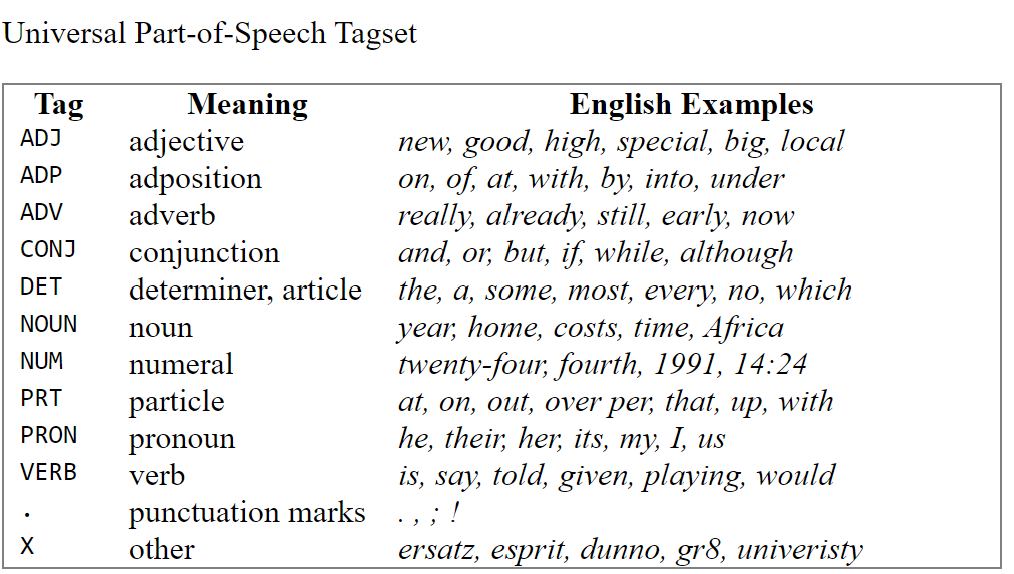

This is useful to extract the key ingredients from our ingredient list. The example are shown as below:

In [24]:
# Let's see how nltk.pos_tag works on our dataset
text = word_tokenize("3 pounds (10 to 12) small beets, scrubbed thoroughly but not peeled")
print(nltk.pos_tag(text))

[('3', 'CD'), ('pounds', 'NNS'), ('(', '('), ('10', 'CD'), ('to', 'TO'), ('12', 'CD'), (')', ')'), ('small', 'JJ'), ('beets', 'NNS'), (',', ','), ('scrubbed', 'VBN'), ('thoroughly', 'RB'), ('but', 'CC'), ('not', 'RB'), ('peeled', 'VBD')]


In [25]:
text = word_tokenize("1 cup of brown sugar")
print(nltk.pos_tag(text))

[('1', 'CD'), ('cup', 'NN'), ('of', 'IN'), ('brown', 'JJ'), ('sugar', 'NN')]


What we want for our dataset:
- **NN**: noun (to capture singular noun such as ‘sugar’)
- **NNS**: noun (to capture plural nouns such as ‘beets’)
- **JJ**: adjective (to capture adjective such as 'brown' in brown sugar)

What we need to remove from our dataset:
- Cooking measures, e.g. cups, pounds, lbs

### a. Recipe Dataframe

In [26]:
recipes = df.copy()

In [27]:
recipes.head(3)

,title,ingredients,tags,directions,calories,Image_Name
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found


In [28]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17740 entries, 0 to 17739
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        17740 non-null  object 
 1   ingredients  17740 non-null  object 
 2   tags         17740 non-null  object 
 3   directions   17740 non-null  object 
 4   calories     14088 non-null  float64
 5   Image_Name   17740 non-null  object 
dtypes: float64(1), object(5)
memory usage: 831.7+ KB


In [29]:
is_noun = lambda tag: (tag == 'NN') | (tag == 'NNS') | (tag == 'JJ')

The list below are extracted from [Wikipedia cooking measurements](https://en.wikibooks.org/wiki/Cookbook:Units_of_measurement), as well as some common measurements such as 'big', 'small', 'large', etc.

In [30]:
measurement = ['ml', 'l', 'dl', 'teaspoon', 'teaspoons', 'tsp', 'tablespoon', 'tablespoons', 'tbsp', 'fluid ounce', 'fl',
              'oz', 'cup', 'pint', 'quart', 'gallon', 'g', 'mg', 'kg', 'pound', 'ounce', 'mm', 'cm', 'm', 'inch', 'in',
              'gram', 'cups', 'bulbs', 'big', 'small', 'large', 'medium', 'lb']

In [31]:
recipes.head(3)

,title,ingredients,tags,directions,calories,Image_Name
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found


In [32]:
def keep_noun(ingredients_list):
    nouns_list = []
    for ingredients in ingredients_list:
        tokenized = nltk.word_tokenize(ingredients)
        nouns = [word for (word, tag) in nltk.pos_tag(tokenized) if is_noun(tag)]
        nouns_list.append(nouns)
    return nouns_list

In [33]:
def remove_measurement_numeric(ingredient):
    all_ingredient = []
    
    for ingredient_input in ingredient:
        ingredient_cleaned = []
        for item in ingredient_input:
            if (item.isalpha() == True) & (item not in measurement):
                ingredient_cleaned.append(item)
        if len(ingredient_cleaned) > 0:
            all_ingredient.append(' '.join(ingredient_cleaned))
                
    return all_ingredient

In [34]:
recipes['ingredients_parsed'] = recipes['ingredients'].progress_apply(keep_noun)

100%|██████████| 17740/17740 [02:25<00:00, 122.07it/s]


In [35]:
recipes['ingredients_parsed'] = recipes['ingredients_parsed'].progress_apply(remove_measurement_numeric)

100%|██████████| 17740/17740 [00:00<00:00, 43399.39it/s]


In [36]:
recipes.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingredients_parsed
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable chicken stock, brown lentils, French green lentils, stalks celery, carrot, sprig fresh thyme, kosher salt..."
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,"[cream, onions, salt, bay leaves, whole cloves, garlic clove, pepper, ground nutmeg, Pinch dried thyme, shallots, bu..."
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,"[fennel bulb anise stalks bulb cut dice feathery garnish, onion, unsalted butter, russet potatoes, broth, milk]"


In [37]:
Ingr_count = pd.Series([item for sublist in recipes['ingredients_parsed'] for item in sublist])
Ingr_count_df = Ingr_count.value_counts().sort_index().rename_axis('ingredients_parsed').reset_index(name='count')

In [38]:
Ingr_count_df.sort_values(by = 'count', ascending = False)

,ingredients_parsed,count
17587,olive oil,5921
28860,sugar,5725
26104,salt,5290
10811,flour,2941
12803,garlic cloves,2888
...,...,...
12306,fresh serrano jalapeño chilies wear gloves,1
12305,fresh serrano jalapeño chilies,1
12304,fresh serrano jalapeño chili fine wear gloves,1
12302,fresh serrano jalapeño chiles,1


**Findings:**
1. 'brown lentils' was successfully extracted from '1 cup dried brown lentils'
2. 'onions' was successfully extracted from '2 medium onions, chopped,'

**However:**
1. Only 'cream' was extracted from '1 1/2 cups whipping cream'
2. 'fennel bulb' was extracted from '1 fennel bulb' when it should only be 'fennel', and 'garlic cloves' was extracted from '1 large garlic cloves' when it should only be 'garlic'
3. These indicates that we need to add more cooking/unit measurements in order to properly extract the ingredients.
4. Furthermore, we also have to remove 'adjective' that does not indicate the key ingredients, such as 'fresh' in 'fresh chilli'.
5. This can be challenging process as there are a lot of measurements and adjective that were used to describe ingredients.
5. Total Unique Ingredients: 32487

## 02. Using ingredient_list extracted from bbc.com

Earlier, we have scrapped an extensive list of 1.1k ingredients from [BBC Food](https://www.bbc.co.uk/food/ingredients/a-z/a/1). All the ingredients in the Epicurious dataset will be matched with the ingredient list from BBC Food. In order to match the ingredients, we have to do the following:
1. Singularize & lowercase all ingredients (e.g. 'Tomatoes' to 'tomato')
2. Get rid of punctuations, symbols, etc
3. Tokenize ingredients in trigram, bigram, and unigram to encapsulate all ingredients such as 'all purpose flour', 'bell pepper', 'avocado'

This method is selected to extract they key ingredient from the ingredient list as the maximum total unique ingredients will be 1.1k, as compared to NLTK POS method which results in 32k ingredients.

### a. Ingredient List Dataframe

In [39]:
ingr = pd.read_csv('./dataset/ingredient_list.csv')
ingr = ingr.rename(columns = {'0': 'Ingredient_ori'})

In [40]:
ingr.head()

,Ingredient_ori
0,Ackee
1,Acorn squash
2,Aduki beans
3,Advocaat
4,Agar-agar


In [41]:
ingr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Ingredient_ori  1171 non-null   object
dtypes: object(1)
memory usage: 9.3+ KB


Add additional ingredients from [source](https://www.allrecipes.com/article/essential-baking-ingredients/), [source](https://www.greenmatters.com/p/recipes-rinds-peels), and [source](https://en.wikipedia.org/wiki/Broth)

In [42]:
baking_ingredients = {'Ingredient_ori': ['all purpose flour', 'whole wheat flour', 'whole grain flour', 'bread flour',
                                      'cake flour', 'pastry flour', 'self rising flour', 'almond flour', 'all purpose flour',
                                      'cornmeal', 'cornstarch', 'baking soda', 'baking powder', 'yeast', 'granulated sugar',
                                      'powdered sugar', 'brown sugar', 'caster sugar', 'coarse sugar', 'fine sugar', 'molasses',
                                      'maple syrup', 'cane syrup', 'agave syrup', 'unsalted butter', 'buttermilk', 'almond milk',
                                      'coconut milk', 'oat milk', 'cream cheese', 'vegetable oil', 'shortening', 'vanilla extract',
                                      'almond extract', 'lemon extract', 'mint extract', 'rum flavoring', 'brandy flavoring',
                                      'vanilla bean', 'ground cloves', 'allspice', 'ginger', 'nutmeg', 'sour cream']}
ingr_add = pd.DataFrame(data = baking_ingredients)

In [43]:
misc_ingredients = {'Ingredient_ori': ['sweet potato', 'apple sauce', 'bamboo shoots', 'cava', 'cherry', 'corn', 'chilli sauce', 'duck',
                                       'fennel seeds', 'ground ginger', 'kumquat', 'mace', 'rosewater', 'salsa', 'tortilla', 'scallion', 
                                       'bell pepper', 'zucchini', 'corn', 'eggplant', 'egg noodle', 'chicken stock', 'chicken broth',
                                       'beef stock', 'beef broth', 'vegetable stock', 'black fungus', 'vegetable broth', 'banana peel',
                                       'orange peel', 'potato peel', 'lemon peel']}
ingr_add_2 = pd.DataFrame(data = misc_ingredients)

In [44]:
ingr = pd.concat([ingr, ingr_add, ingr_add_2])

In [45]:
def singularize_text(input):
    tokenized = nltk.word_tokenize(input)
    item_singular_list = []
    
    for item in tokenized:
        item_singular = singularize(item)
        item_singular_list.append(item_singular)
    
    return ' '.join(item_singular_list)

In [46]:
ingr.head()

,Ingredient_ori
0,Ackee
1,Acorn squash
2,Aduki beans
3,Advocaat
4,Agar-agar


In [47]:
# Singularize all elements in ingredients
ingr['Ingredients'] = ingr['Ingredient_ori'].apply(singularize_text)

In [48]:
# Lowercase all elements in the ingredients
ingr['Ingredients'] = [str.lower(i) for i in ingr['Ingredients']]

In [49]:
ingr.head()

,Ingredient_ori,Ingredients
0,Ackee,ackee
1,Acorn squash,acorn squash
2,Aduki beans,aduki bean
3,Advocaat,advocaat
4,Agar-agar,agar-agar


**Observations:** item 3 'Aduki Beans' are converted to 'aduki bean'

In [50]:
ingr = ingr.drop_duplicates(subset = 'Ingredients')

In [51]:
ingr.reset_index(drop = True, inplace = True)

In [52]:
# remove 's and ' from list
ingr['Ingredients'] = ingr['Ingredients'].str.replace("'s", "", regex=False)
ingr['Ingredients'] = ingr['Ingredients'].str.replace("'", "", regex=False)
ingr['Ingredients'] = ingr['Ingredients'].str.replace("(", "", regex=False)
ingr['Ingredients'] = ingr['Ingredients'].str.replace(")", "", regex=False)

In [53]:
ingr['length'] = [len(i.split()) for i in ingr['Ingredients']]

In [54]:
ingr.sort_values(by = 'length', ascending = False).head()

,Ingredient_ori,Ingredients,length
428,Garlic and herb cream cheese,garlic and herb cream cheese,5
74,Best end of lamb,best end of lamb,4
1040,Swiss rolls and roulades,swiss roll and roulade,4
1145,White wine vinegar,white wine vinegar,3
569,Leg of lamb,leg of lamb,3


**Observations:** <br>
There are only 3 items that has character length more than 3. Let's analyse these 3 items. <br>
- 'garlic and herb cream cheese' can be considered as 'cream cheese' which is in our ingredient list
- 'best end of lamb' can be considered as 'lamb' which is in our ingredient list
- 'swiss roll and roulade' are not commonly used ingredient

Hence we will not consider these 3 items and will only use unigram, bigram and trigram for our analysis

### b. Recipe Dataframe

In [55]:
# re-import recipe under different name for easy data manipulation
recipe = df.copy()

In [56]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found


#### (i) Ingredients Column

In [57]:
def parsing_ingredients(data):
    ingredient_list = []
    for item in data:
        item = re.sub(r'[^a-zA-Z]', ' ', item).lower().strip().replace('garlic clove', 'garlic')
        ingredient_list.append(item)
    return ' '.join(ingredient_list)

In [58]:
recipe['ingr_list'] = recipe['ingredients'].progress_apply(parsing_ingredients)

100%|██████████| 17740/17740 [00:00<00:00, 40897.01it/s]


In [59]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,cups low sodium vegetable or chicken stock cup dried brown lentils cup dried french green lentils stalks celery cho...
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,cups whipping cream medium onions chopped teaspoons salt bay leaves whole cloves large garlic crushed teaspoon pep...
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,fennel bulb sometimes called anise stalks discarded bulb cut into inch dice and feathery leaves reserved fo...


In [60]:
recipe['ingr_list'] = recipe['ingr_list'].progress_apply(singularize_text)

100%|██████████| 17740/17740 [00:27<00:00, 649.55it/s]


In [61]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,cup low sodium vegetable or chicken stock cup dried brown lentil cup dried french green lentil stalk celery chopped ...
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,cup whipping cream medium onion chopped teaspoon salt bay leaf whole clove large garlic crushed teaspoon pepper teas...
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,fennel bulb sometime called anise stalk discarded bulb cut into inch dice and feathery leaf reserved for garnish oni...


In [62]:
# Define a function to parse ingredients according to Ingredient List Dataframe scrapped earlier

def tokenize_ingredients(ingredients):
    tokenized = nltk.word_tokenize(ingredients)
    
    #find trigram ingredients
    ingredient_trigram = []
    trigram = [" ".join(pair) for pair in nltk.trigrams(tokenized)]
    
    for item in trigram:
        if item in ingr['Ingredients'].tolist():
            if item not in ingredient_trigram:
                ingredient_trigram.append(item)
            
    #if item found in trigram, it shall be removed from the ingredient list to prevent duplicate
    #i.e. if item is detected as 'rack of lamb', it shall not be detected as 'lamb'
    for item in ingredient_trigram:
        ingredients = ingredients.replace(item, "")        
    
    #find bigram ingredients
    ingredient_bigram = []
    bigram = [" ".join(pair) for pair in nltk.bigrams(tokenized)]
    
    for item in bigram:
        if item in ingr['Ingredients'].tolist():
            if item not in ingredient_bigram:
                ingredient_bigram.append(item)
            
    #if item found in bigram, it shall be removed from the ingredient list to prevent duplicate
    #i.e. if item is detected as 'unsalted', it shall not be detected as 'butter'
    for item in ingredient_bigram:
        ingredients = ingredients.replace(item, "")
        
    unigram = nltk.word_tokenize(ingredients)
    ingredient_unigram = []
    
    for item in unigram:
        if item in ingr['Ingredients'].tolist():
            if item not in ingredient_unigram:
                ingredient_unigram.append(item)
            
    ingredient = ingredient_unigram + ingredient_bigram + ingredient_trigram
    return ingredient

In [63]:
recipe['ingr_list'] = recipe['ingr_list'].progress_apply(tokenize_ingredients)

100%|██████████| 17740/17740 [00:56<00:00, 313.93it/s]


In [64]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju..."
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,"[onion, salt, clove, garlic, pepper, nutmeg, thyme, shallot, butter, egg, port, currant, lettuce, peppercorn, parsle..."
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,"[fennel, anise, onion, potato, milk, unsalted butter, chicken broth]"


In [65]:
def snakecase(ingredient):
    ingredient_list = []
    for item in ingredient:
        item = item.replace(" ", "_")
        ingredient_list.append(item)
    return ' '.join(ingredient_list)

In [66]:
recipe['ingr_parsed'] = recipe['ingr_list'].progress_apply(snakecase)

100%|██████████| 17740/17740 [00:00<00:00, 281357.47it/s]


In [67]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,"[onion, salt, clove, garlic, pepper, nutmeg, thyme, shallot, butter, egg, port, currant, lettuce, peppercorn, parsle...",onion salt clove garlic pepper nutmeg thyme shallot butter egg port currant lettuce peppercorn parsley baguette suga...
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,"[fennel, anise, onion, potato, milk, unsalted butter, chicken broth]",fennel anise onion potato milk unsalted_butter chicken_broth


**Observations:**
1. We have removed all the digits & symbols `1 cup dried brown lentil` to `brown_lentil`
2. We have singularize all ingredietns `2 medium onions` to `onion`

#### (ii) Title Column

In [68]:
# Parsing title
recipe['title'] = [x.strip() for x in recipe['title']]
recipe['title_parsed'] = [i.replace("-", " ") for i in recipe['title']]
recipe['title_parsed'] = [i.replace("–", " ") for i in recipe['title_parsed']]
recipe['title_parsed'] = [re.sub(r'[^a-zA-Z]', ' ', i) for i in recipe['title_parsed']]
recipe['title_parsed'] = [str.lower(i) for i in recipe['title_parsed']]

In [69]:
recipe.head(1)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple and turkey wrap


In [70]:
recipe['title_parsed'] = recipe['title_parsed'].progress_apply(singularize_text)

100%|██████████| 17740/17740 [00:04<00:00, 3824.50it/s]


In [71]:
recipe.head(1)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple and turkey wrap


In [72]:
recipe['title_parsed'] = recipe['title_parsed'].progress_apply(tokenize_ingredients)

100%|██████████| 17740/17740 [00:08<00:00, 2103.36it/s]


In [73]:
recipe.head(1)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,"[lentil, apple, turkey, wrap]"


In [74]:
recipe['title_parsed'] = recipe['title_parsed'].progress_apply(snakecase)

100%|██████████| 17740/17740 [00:00<00:00, 556109.93it/s]


In [75]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple turkey wrap
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill, Bon Appétit]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,"[onion, salt, clove, garlic, pepper, nutmeg, thyme, shallot, butter, egg, port, currant, lettuce, peppercorn, parsle...",onion salt clove garlic pepper nutmeg thyme shallot butter egg port currant lettuce peppercorn parsley baguette suga...,red_onion
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet, New York]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,"[fennel, anise, onion, potato, milk, unsalted butter, chicken broth]",fennel anise onion potato milk unsalted_butter chicken_broth,potato fennel soup


**Observations:** Now our ingredients are ready (yey!)

#### (iii) Tag Column

In [76]:
# 'Epicurious' is a subsidiary of 'Bon Appétit'. Remove 'Bon Appétit' tags as it has no significant meaning to our model.
def remove_bonapetit (item):
    if 'Bon Appétit' in item:
        item.remove('Bon Appétit')
    if 'New York' in item:
        item.remove('New York')
    return item

In [77]:
recipe['tags'] = recipe['tags'].apply(remove_bonapetit)

In [78]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple turkey wrap
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,"[onion, salt, clove, garlic, pepper, nutmeg, thyme, shallot, butter, egg, port, currant, lettuce, peppercorn, parsle...",onion salt clove garlic pepper nutmeg thyme shallot butter egg port currant lettuce peppercorn parsley baguette suga...,red_onion
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,"[fennel, anise, onion, potato, milk, unsalted butter, chicken broth]",fennel anise onion potato milk unsalted_butter chicken_broth,potato fennel soup


In [79]:
recipe['tags_str'] = recipe['tags'].apply(snakecase)
recipe['tags_str'] = [x.lower() for x in recipe['tags_str']]
recipe['tags_str'] = [x.replace('kid-friendly', 'kid_friendly') for x in recipe['tags_str']]
recipe['tags_str'] = [x.replace('peanut free', 'peanut_free') for x in recipe['tags_str']]
recipe['tags_str'] = [x.replace('wheat/gluten-free', 'gluten_free') for x in recipe['tags_str']]

In [80]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed,tags_str
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple turkey wrap,sandwich bean fruit tomato turkey vegetable kid_friendly apple lentil lettuce cookie
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,"[onion, salt, clove, garlic, pepper, nutmeg, thyme, shallot, butter, egg, port, currant, lettuce, peppercorn, parsle...",onion salt clove garlic pepper nutmeg thyme shallot butter egg port currant lettuce peppercorn parsley baguette suga...,red_onion,food_processor onion pork bake bastille_day new_year's_eve dried_fruit port winter chill
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,"[fennel, anise, onion, potato, milk, unsalted butter, chicken broth]",fennel anise onion potato milk unsalted_butter chicken_broth,potato fennel soup,soup/stew dairy potato vegetable fennel gourmet


The average [average calories in a meal](https://globalnews.ca/news/3615212/this-is-what-your-breakfast-lunch-and-dinner-calories-actually-look-like/) is 500-700 calories. Categorizing meal under 500 calories as 'low_calories'

In [81]:
len(recipe[recipe['calories'] < 500])

9342

In [82]:
recipe.head(1)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed,tags_str
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple turkey wrap,sandwich bean fruit tomato turkey vegetable kid_friendly apple lentil lettuce cookie


In [83]:
tag_df = recipe[['tags_str']].copy()
tag_df.head(3)

,tags_str
0,sandwich bean fruit tomato turkey vegetable kid_friendly apple lentil lettuce cookie
1,food_processor onion pork bake bastille_day new_year's_eve dried_fruit port winter chill
2,soup/stew dairy potato vegetable fennel gourmet


In [84]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()

cvec_tag = pd.DataFrame(
    cvec.fit_transform(tag_df['tags_str']).toarray(),
    columns = cvec.get_feature_names_out(),
)

In [85]:
new_tag = cvec_tag[['kid_friendly', 'peanut_free', 'vegetarian', 'gluten_free',
                    'breakfast', 'brunch', 'lunch', 'dinner', 'dessert']]

In [86]:
tag_df = tag_df.join(new_tag)
tag_df = tag_df.join(recipe['calories'])

In [87]:
conditions = [(tag_df['calories'] == 0), (tag_df['calories'] > 0) & (tag_df['calories'] <= 500), (tag_df['calories'] > 500)]
values = [0, 1, 0]
tag_df['low_calories'] = np.select(conditions, values)

In [88]:
tag_df.drop(columns = ['tags_str', 'calories'], inplace = True)

In [89]:
tag_df.head(3)

,kid_friendly,peanut_free,vegetarian,gluten_free,breakfast,brunch,lunch,dinner,dessert,low_calories
0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1


In [90]:
recipe = recipe.join(tag_df)

In [91]:
recipe.head(3)

,title,ingredients,tags,directions,calories,Image_Name,ingr_list,ingr_parsed,title_parsed,tags_str,kid_friendly,peanut_free,vegetarian,gluten_free,breakfast,brunch,lunch,dinner,dessert,low_calories
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Kid-Friendly, Apple, Lentil, Lettuce, Cookie]","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",426.0,lentil-apple-and-turkey-wrap-239173,"[vegetable, celery, carrot, thyme, salt, tomato, apple, lettuce, chicken stock, brown lentil, green lentil, lemon ju...",vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple turkey wrap,sandwich bean fruit tomato turkey vegetable kid_friendly apple lentil lettuce cookie,1,0,0,0,0,0,0,0,0,1
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Food Processor, Onion, Pork, Bake, Bastille Day, New Year's Eve, Dried Fruit, Port, Winter, Chill]","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",403.0,image_not_found,"[onion, salt, clove, garlic, pepper, nutmeg, thyme, shallot, butter, egg, port, currant, lettuce, peppercorn, parsle...",onion salt clove garlic pepper nutmeg thyme shallot butter egg port currant lettuce peppercorn parsley baguette suga...,red_onion,food_processor onion pork bake bastille_day new_year's_eve dried_fruit port winter chill,0,0,0,0,0,0,0,0,0,1
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[Soup/Stew, Dairy, Potato, Vegetable, Fennel, Gourmet]","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",165.0,image_not_found,"[fennel, anise, onion, potato, milk, unsalted butter, chicken broth]",fennel anise onion potato milk unsalted_butter chicken_broth,potato fennel soup,soup/stew dairy potato vegetable fennel gourmet,0,0,0,0,0,0,0,0,0,1


# 03. EDA

In [92]:
recipe['ingr_list'] = recipe['ingr_parsed'].str.split()
ingr_count = pd.Series([item for sublist in recipe['ingr_list'] for item in sublist])
ingr_count_df = ingr_count.value_counts().sort_index().rename_axis('ingredient').reset_index(name='count')

In [93]:
ingr_count_df.sort_values(by = 'count', ascending = False)

,ingredient,count
709,salt,8402
534,olive_oil,6104
326,garlic,5514
798,sugar,4734
535,onion,4204
...,...,...
671,rennet,1
145,charcuterie,1
687,rock_salt,1
693,rosewater,1


In [94]:
top_10_ingr = ingr_count_df.sort_values(by = 'count', ascending = False).head(10)

In [95]:
top_10_ingr = top_10_ingr.replace('all_purpose_flmy', 'all_purpose_flour')

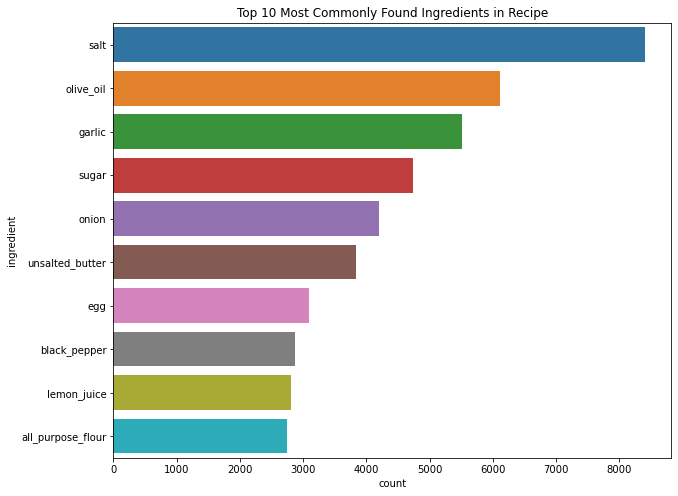

In [96]:
plt.figure(figsize=(10, 8))
sns.barplot(data = top_10_ingr, y = 'ingredient', x = 'count')
plt.title("Top 10 Most Commonly Found Ingredients in Recipe");

In [97]:
tags_count = pd.Series([item for sublist in recipe['tags'] for item in sublist])
tags_count_df = tags_count.value_counts().sort_index().rename_axis('tags').reset_index(name='count')

In [98]:
tags_count_df.sort_values(by = 'count', ascending = False).head(10)

,tags,count
450,Peanut Free,7564
571,Soy Free,7279
621,Tree Nut Free,6302
633,Vegetarian,6027
239,Gourmet,5729
309,Kosher,5511
459,Pescatarian,5399
499,Quick & Easy,4724
651,Wheat/Gluten-Free,4357
32,Bake,4033


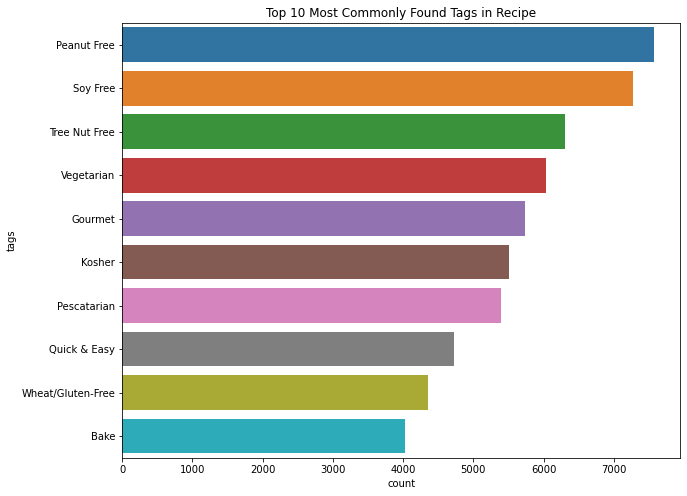

In [99]:
plt.figure(figsize=(10, 8))
sns.barplot(data = tags_count_df.sort_values(by = 'count', ascending = False).head(10), y = 'tags', x = 'count')
plt.title("Top 10 Most Commonly Found Tags in Recipe");

# 04. Modelling

## 01. 'Search Recipe 🔍' FEATURE

To create the 'Search Recipe' feature, first we filter our dataframe based on the input ingredients. Next, we create a TF-IDF to generate embeddings for each ingredients. The IDF measures the importance of a term across the whole corpus. IDF will weigh down terms that are very common across a corpus (in our case words like salt, sugar, olive oil, butter, garlic, etc.) and weighs up rare terms. This is useful for us as it will give us better distinguishing power between recipes as the ingredients that are scaled-down will be ingredients that the user will tend to not give as an input to the recommendation system.

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [101]:
tfidf = TfidfVectorizer()

In [102]:
# create new dataframe (TF-IDF) of the ingredients    
tfidf_recipe = pd.DataFrame(tfidf.fit_transform(recipe['ingr_parsed']).toarray(),
                            columns = tfidf.get_feature_names_out(),
                            index = recipe['title'])

In [103]:
def search_recipes(ingredient):
    #transform ingredient to lowercase & singular
    ingredient = [str.lower(i) for i in ingredient]
    ingredient = [singularize_text(i) for i in ingredient]
    
    snakecase_ingredient = []
    for i in ingredient:
        i = i.replace(' ', '_')
        snakecase_ingredient.append(i)    
        
    recipe_ingredient = tfidf_recipe.copy()
    
    # filter df based on the available ingredients
    for i in snakecase_ingredient:
        recipe_ingredient = recipe_ingredient[recipe_ingredient[i] > 0]
    
    # join back with original dataframe
    recipe_ingredient.reset_index(inplace = True)
    recipe_ingredient = recipe_ingredient[['title']]
    recipe_ingredient = recipe_ingredient.join(recipe.set_index('title'), on='title')
    
    # get scores
    ingr_tfidf = tfidf.transform(recipe_ingredient['ingr_parsed'])
    title_tfidf = tfidf.transform(recipe_ingredient['title_parsed'])
    i_vector = tfidf.transform([' '.join(snakecase_ingredient)])
    recipe_scores = ingr_tfidf*i_vector.T*0.5 + title_tfidf*i_vector.T*0.5

    #sort scores & get the top 3 similarity scores, then get the recipe index
    sorted_index = pd.Series(recipe_scores.toarray().T[0]).sort_values(ascending = False)[0:3].index
    
    # return
    for i in sorted_index:
        print(recipe_ingredient.iloc[i]['title'])
        image_name = recipe_ingredient.iloc[i]['Image_Name']
        image_path = 'dataset/food_images/' + image_name + '.jpg'
        display(Image(filename = image_path, width=150))

Bacon, Egg, and Tomato Toast


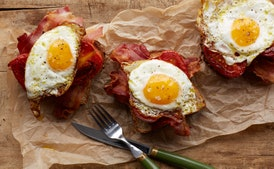

Spicy Bacon and Egg


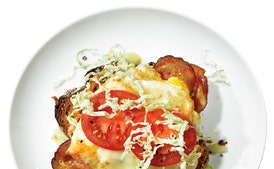

Bacon, Egg, and Tomato Club Sandwiches


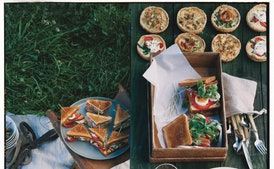

In [104]:
search_recipes(['Tomatoes', 'bacon', 'egg'])

Tomato Egg Cups


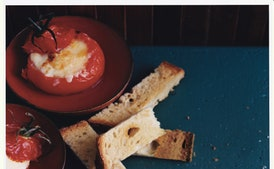

Poached Eggs with Tomato Cilantro Sauce


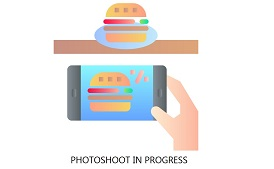

Bacon, Egg, and Tomato Toast


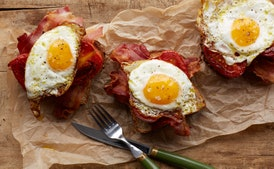

In [105]:
search_recipes(['tomato', 'egg'])

Roasted Tomatoes


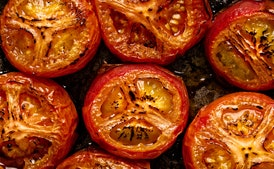

Baked Tomatoes Teagarden


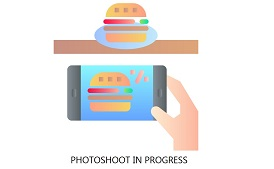

Baked Tomatoes


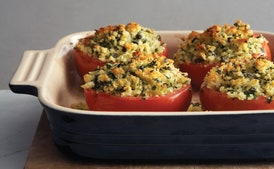

In [106]:
search_recipes(['tomato'])

## 02. 'You might also like ❤' FEATURE

'You might also like ❤' feature are build using content-based recommendation system which enables us to recommend recipes to people based on the original recipes that they selected. To measure the cosine-similarity between recipes, 'tag' features was used. The 'category' feature contains key information such as: the main ingredient of the recipe (i.e. Tomato, Egg), ocassion (i.e. New Year, Christmas, Birthday), the dietary information (i.e. Peanut-Free, Glutten-Free), as well as the timing (i.e. Breakfast, Lunch). An example of a 'category' for 'Lentil, Apple, and Turkey Wrap' is Kid-Friendly, Sandwich, Bean, Fruit, Tomato, turkey, Vegetable, Apple, Lentil, Lettuce.

In [107]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

In [108]:
tfidf_categories = pd.DataFrame(
    tfidf.fit_transform(recipe['tags_str']).toarray(),
    columns = tfidf.get_feature_names_out(),
    index = recipe['title'])

cosine_sim = linear_kernel(tfidf_categories, tfidf_categories)

In [109]:
def get_recommendations(title):
    recipe_index = recipe[recipe['title'] == title].index[0]
    distances = cosine_sim[recipe_index]
    recipe_list = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:4]
    
    # return
    for i in recipe_list:
        print(recipe.iloc[i[0]]['title'])
        image_name = recipe.iloc[i[0]]['Image_Name']
        image_path = 'dataset/food_images/' + image_name + '.jpg'
        display(Image(filename = image_path, width=150))

Classic Tomato Toast with Mayonnaise and Chives


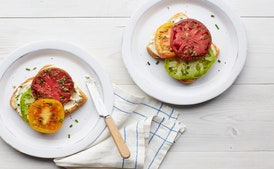

Spanish-Style Tomato Toast with Garlic and Olive Oil


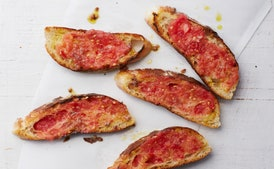

Panzanella Tomato Toast with Crispy Capers and Basil Leaves


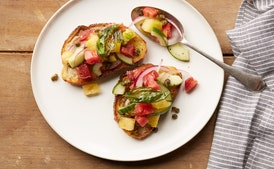

In [110]:
get_recommendations("Bacon, Egg, and Tomato Toast")

Blueberry Lemon Corn Muffins


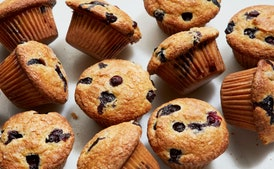

Blueberry Corn Muffins


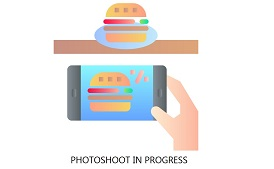

Meyer Lemon Budino


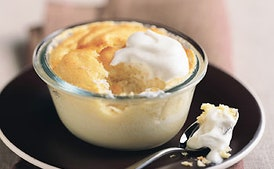

In [111]:
get_recommendations("Lemon and Blueberry Shortcakes")

## 03. 'Dietary Preferences 🙅🏻‍♀️' FEATURE

To cater for different dietary preferences, we have created 5 recipe filters: kid_friendly, peanut_free, vegetarian, gluten_free, low_calories.

In [112]:
def get_recommendations_with_filter(title, kid_friendly, peanut_free, vegetarian, gluten_free, low_calories):
    
    if kid_friendly == 0:
        kid_friendly = recipe['kid_friendly']
    if peanut_free == 0:
        peanut_free = recipe['peanut_free']
    if vegetarian == 0:
        vegetarian = recipe['vegetarian']
    if gluten_free == 0:
        gluten_free = recipe['gluten_free']
    if low_calories == 0:
        low_calories = recipe['low_calories']
            
    selected_recipe = recipe[(recipe['kid_friendly'] == kid_friendly) & (recipe['peanut_free'] == peanut_free) &
                            (recipe['vegetarian'] == vegetarian) & (recipe['gluten_free'] == gluten_free) &
                            (recipe['low_calories'] == low_calories)]
    
    selected_recipe.reset_index(drop = True, inplace = True)
    
    # Get cosine similarity score
    tfidf_recipe = pd.DataFrame(tfidf.fit_transform(selected_recipe['ingr_parsed']).toarray())

    cosine_similarity = linear_kernel(tfidf_recipe, tfidf_recipe)
    ind = pd.Series(selected_recipe.index, index=selected_recipe['title'])
    idx = ind[title]
    sim_scores = list(enumerate(cosine_similarity[idx]))
    
    # Sort the recipe based on the similarity scores & return 3 most similar recipes
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:4]
    recipe_indices = [i[0] for i in sim_scores]
    return selected_recipe['title'].iloc[recipe_indices]

In [113]:
get_recommendations_with_filter('Chocolate Cake', 0, 0, 0, 0, 0)

6851            Almond Sablé Dough
8696                    Frangipane
3001    Chocolate-Pistachio Sablés
Name: title, dtype: object

## 04. 'Random Recipe' FEATURE

If there's no ingredient selected from the ingredient list, random recipe will be generated based on current time.

In [114]:
from datetime import datetime
hour = int(datetime.now().strftime('%H'))

In [115]:
hour

8

In [116]:
tags_count_df[(tags_count_df['tags'] == 'Breakfast') | (tags_count_df['tags'] == 'Brunch') |
              (tags_count_df['tags'] == 'Lunch') | (tags_count_df['tags'] == 'Dinner') |
              (tags_count_df['tags'] == 'Dessert')]

,tags,count
65,Breakfast,676
75,Brunch,782
175,Dessert,3152
178,Dinner,2534
347,Lunch,1284


In [117]:
if (hour >= 6) & (hour < 10):
    print("It is breakfast time!")
    recipe_time = recipe[recipe['breakfast'] == 1]
    
elif (hour >= 10) & (hour < 11):
    print("It is brunch time!")
    recipe_time = recipe[recipe['brunch'] == 1]
    
elif (hour >= 11) & (hour < 13):
    print("It is lunch time!")
    recipe_time = recipe[recipe['lunch'] == 1]
    
elif (hour >= 13) & (hour < 17):
    print("It is dessert time!")
    recipe_time = recipe[recipe['dessert'] == 1]
    
elif (hour >= 17) & (hour < 22):
    print("It is dinner time!")
    recipe_time = recipe[recipe['dinner'] == 1]
    
elif (hour >= 22) & (hour < 6):
    print("It is supper time")
    recipe_time = recipe[recipe['dessert'] == 1]

recipe_time.reset_index(drop = True, inplace = True)
recipe_index_list = recipe_time[['title']].index.tolist()
recipe_random_list = random.sample(recipe_index_list, 5)

It is breakfast time!


In [118]:
recipe_random_list

[562, 588, 496, 335, 239]

# 05. FUTURE WORKS

## INGREDIENTS USED TOGETHER (CBOW)

Word2Vec is a 2-layer neural network that produces word embeddings. It takes in a corpus of text as an input (a collection of individual documents) and maps each word to a vector in Euclidean space. The end goal is to have a text representation that captures distributional similarities between words. That is, words that often appear in similar contexts are mapped to vectors separated by a shorter Euclidean distance (the L2 norm).

In the context of recipe ingredients, Word2vec captured similarities between recipe ingredients that are commonly used together. For example, cocoa powder which is commonly used when baking is most similar to other baking ingredients such as cake flour, cream of tartar, etc.

In [119]:
import gensim
from gensim.models import Word2Vec

In [120]:
# get ingredients sorted in alphabetical order
def get_and_sort_corpus(data):
    ingr_sorted = []
    for item in data:
        item = list(item.split(" "))
        item.sort()
        ingr_sorted.append(item)
    return ingr_sorted

In [121]:
sorted_recipe = get_and_sort_corpus(recipe['ingr_parsed'])

In [122]:
sorted_recipe[0:3]

[['apple',
  'black_pepper',
  'brown_lentil',
  'carrot',
  'celery',
  'chicken_stock',
  'flmy_tortilla',
  'green_lentil',
  'lemon_juice',
  'lettuce',
  'olive_oil',
  'salt',
  'thyme',
  'tomato',
  'turkey_breast',
  'vegetable'],
 ['all_purpose_flmy',
  'baguette',
  'bay_leaf',
  'butter',
  'chicken_broth',
  'clove',
  'currant',
  'egg',
  'french_bread',
  'garlic',
  'lettuce',
  'nutmeg',
  'olive_oil',
  'onion',
  'parsley',
  'pepper',
  'peppercorn',
  'pork_loin',
  'port',
  'red_onion',
  'red_wine',
  'red_wine_vinegar',
  'salt',
  'shallot',
  'sugar',
  'thyme',
  'whipping_cream'],
 ['anise',
  'chicken_broth',
  'fennel',
  'milk',
  'onion',
  'potato',
  'unsalted_butter']]

In [123]:
# calculate average length of each document 
def get_window(data):
    total_length = 0
    for item in data:
        item = list(item.split(" "))
        total_length += len(item)
    print(f"Total recipe: {len(data)}")
    print(f"Total ingredient length: {total_length}")
    print(f"Average ingredient length: {round(total_length/len(data),2)}")

In [124]:
get_window(recipe['ingr_parsed'])

Total recipe: 17740
Total ingredient length: 177954
Average ingredient length: 10.03


In [125]:
# train and save CBOW Word2Vec model
# sg=0 -> CBOW model, sg=1 -> skip-gram
# window = ave ingredient length - 1
# min_count = 1 to include all ingredients

model_cbow = gensim.models.Word2Vec(sg = 0, window = 7, min_count = 1)

In [126]:
model_cbow.build_vocab(sorted_recipe)

In [127]:
model_cbow.train(sorted_recipe, total_examples = model_cbow.corpus_count, epochs = model_cbow.epochs)

(569414, 889770)

In [128]:
model_cbow.wv.most_similar('cocoa_powder', topn = 5)

[('chocolate', 0.9916291832923889),
 ('corn_syrup', 0.9895647764205933),
 ('cake_flmy', 0.9794131517410278),
 ('cookies', 0.9669800400733948),
 ('granulated_sugar', 0.961874783039093)]

# 06. EXPORT FILE

In [129]:
import pickle

In [130]:
ingr_count_df.head()

,ingredient,count
0,acorn_squash,20
1,agave_syrup,23
2,ajwain,1
3,ale,17
4,aleppo_pepper,20


In [131]:
ingr.head()

,Ingredient_ori,Ingredients,length
0,Ackee,ackee,1
1,Acorn squash,acorn squash,2
2,Aduki beans,aduki bean,2
3,Advocaat,advocaat,1
4,Agar-agar,agar-agar,1


In [132]:
ingr_all = ingr.copy()
ingr_all['ingredient_snakecase'] = [x.replace(' ', '_') for x in ingr_all['Ingredients']]
ingr_all.head()

,Ingredient_ori,Ingredients,length,ingredient_snakecase
0,Ackee,ackee,1,ackee
1,Acorn squash,acorn squash,2,acorn_squash
2,Aduki beans,aduki bean,2,aduki_bean
3,Advocaat,advocaat,1,advocaat
4,Agar-agar,agar-agar,1,agar-agar


In [133]:
ingr_used = ingr_count_df.join(ingr_all.set_index('ingredient_snakecase'), on = 'ingredient')

In [134]:
ingr_used.head()

,ingredient,count,Ingredient_ori,Ingredients,length
0,acorn_squash,20,Acorn squash,acorn squash,2
1,agave_syrup,23,agave syrup,agave syrup,2
2,ajwain,1,Ajwain,ajwain,1
3,ale,17,Ale,ale,1
4,aleppo_pepper,20,Aleppo pepper,aleppo pepper,2


In [155]:
recipe_used = recipe.copy()

In [157]:
recipe_used.drop(columns = ['calories', 'ingr_list', 'tags'], inplace = True)

In [161]:
recipe_used.head(3)

,title,ingredients,directions,Image_Name,ingr_parsed,title_parsed,tags_str,kid_friendly,peanut_free,vegetarian,gluten_free,breakfast,brunch,lunch,dinner,dessert,low_calories
0,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock, 1 cup dried brown lentils, 1/2 cup dried French green lentils, 2 stal...","[1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat ...",lentil-apple-and-turkey-wrap-239173,vegetable celery carrot thyme salt tomato apple lettuce chicken_stock brown_lentil green_lentil lemon_juice olive_oi...,lentil apple turkey wrap,sandwich bean fruit tomato turkey vegetable kid_friendly apple lentil lettuce cookie,1,0,0,0,0,0,0,0,0,1
1,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, chopped, 5 teaspoons salt, 3 bay leaves, 3 whole cloves, 1 large garlic...","[Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and ...",image_not_found,onion salt clove garlic pepper nutmeg thyme shallot butter egg port currant lettuce peppercorn parsley baguette suga...,red_onion,food_processor onion pork bake bastille_day new_year's_eve dried_fruit port winter chill,0,0,0,0,0,0,0,0,0,1
2,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalks discarded, bulb cut into 1/2-inch dice, and feathery leaves reserved...","[In a large heavy saucepan cook diced fennel and onion in butter over moderate heat, stirring, until softened, about...",image_not_found,fennel anise onion potato milk unsalted_butter chicken_broth,potato fennel soup,soup/stew dairy potato vegetable fennel gourmet,0,0,0,0,0,0,0,0,0,1


In [158]:
recipe_used.to_pickle('recipes.pkl')
ingr_used.to_pickle('ingredients.pkl')
#pickle.dump(cosine_sim, open('recipe_recommendations.pkl','wb'))